<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn 
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings ("ignore")



In [2]:
df = pd.read_csv ("Online+Retail.csv", sep = ",", header = 0, engine = 'python')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### The steps are broadly:
- read and understand the data
- clean the data 
- Prepare the data for modelling
- modelling
- fimnal analysis and recommendations


In [5]:
df.isnull ().sum ()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
#missing values
round (100 *((df.isnull().sum () )/len (df)), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [7]:
#drop alll rows having missing values 
df = df.dropna()
df.shape

(406829, 8)

### 2. Data preperation

- R - recency : Number of days since last purchase
- F - frequency : Number of transactions
- M - monetory volume : Total mnumber of transactions (revenue contributed)

In [8]:
# monetory 
# new column amount 
df['amount'] = df ['Quantity']* df ['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [9]:
grouped_df = df.groupby ('CustomerID')['amount'].sum()
grouped_df = grouped_df.reset_index ()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [10]:
#frequency
frequency = df.groupby ('CustomerID')['InvoiceNo'].count ()
frequency = frequency. reset_index ()
frequency.columns  = ['CustomerID','frequency']
frequency

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


In [11]:
grouped_df = pd.merge (grouped_df, frequency, on = 'CustomerID', how ='inner')
grouped_df

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17
...,...,...,...
4367,18280.0,180.60,10
4368,18281.0,80.82,7
4369,18282.0,176.60,13
4370,18283.0,2094.88,756


#recency 
 cust - 3: 300 days ago, 200 50, 10, 4  

In [12]:
#Invoice date to be converted to the date time value 
df['InvoiceDate'] = pd.to_datetime (df['InvoiceDate'], format ='%d-%m-%Y %H:%M')


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [14]:
#lets compute the maximum date 
max_date = max (df ['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [15]:
df ['diff'] = max_date - df['InvoiceDate']
df.head ()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [16]:
#recency
last_purchase = df.groupby ('CustomerID') ['diff'].min ()
last_purchase = last_purchase.reset_index ()
last_purchase.head ()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [17]:
grouped_df = pd.merge (grouped_df, last_purchase, on = 'CustomerID', how ='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head ()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [18]:
# number of days only 
import datetime as dt

In [19]:
grouped_df ['recency'] = grouped_df ['recency'].dt.days

In [20]:
grouped_df.head ()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


{'whiskers': [<matplotlib.lines.Line2D at 0x1b24cdbc4f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b24cdbcbb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b24cdbc190>],
 'medians': [<matplotlib.lines.Line2D at 0x1b24cef42b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b24cef4610>],
 'means': []}

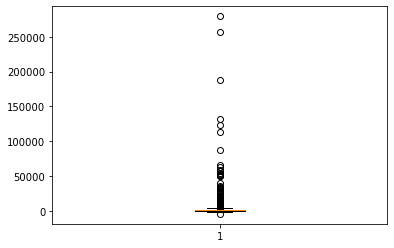

In [21]:
# 1. outlier treatment
plt.boxplot (grouped_df['amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1b24d3e9880>,
 'caps': [<matplotlib.lines.Line2D at 0x1b24d3e9f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b24d3e9520>],
 'medians': [<matplotlib.lines.Line2D at 0x1b24ce2f640>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b24ce2f9a0>],
 'means': []}

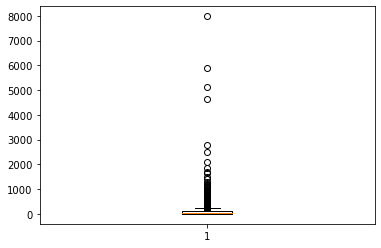

In [22]:
# 1. outlier treatment
plt.boxplot (grouped_df['frequency'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1b25f231fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b25f2426a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b25f231c40>],
 'medians': [<matplotlib.lines.Line2D at 0x1b25f242d60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b25834c100>],
 'means': []}

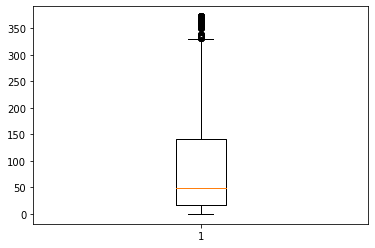

In [23]:
# 1. outlier treatment
plt.boxplot (grouped_df['recency'])

In [24]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile (0.05)
Q3 = grouped_df.amount.quantile (0.95)
IQR = Q3 - Q1 
grouped_df = grouped_df [(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount >= Q3 + 1.5*IQR)]

# removing (statistical) outliers for recency
Q1 = grouped_df.recency.quantile (0.05)
Q3 = grouped_df.recency.quantile (0.95)
IQR = Q3 - Q1 
grouped_df = grouped_df [(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount >= Q3 + 1.5*IQR)]

# removing (statistical) outliers for frequency
Q1 = grouped_df.frequency.quantile (0.05)
Q3 = grouped_df.frequency.quantile (0.95)
IQR = Q3 - Q1 
grouped_df = grouped_df [(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount >= Q3 + 1.5*IQR)]

In [25]:
# 2. rescaling
rfm_df = grouped_df [['amount','frequency','recency']]

#instantiate a scaler 
scaler = StandardScaler ()

#fit_transfrorm

rfm_df_scaled = scaler.fit_transform (rfm_df)
rfm_df_scaled 

array([[ 1.46958542e+00, -6.80302767e-02,  4.18590593e-01],
       [-5.17185113e-01, -2.33928072e-01, -2.95378644e-01],
       [-5.38998526e-01, -4.78409032e-01,  1.00274724e+00],
       [-5.16191770e-01, -4.04527423e-01,  4.18590593e-01],
       [-3.21673603e-01,  2.52722915e+00, -3.27831791e-01],
       [-4.73978976e-01, -4.36095020e-01, -2.30472350e-01],
       [-5.63508668e-01, -5.06618374e-01, -6.82066143e-02],
       [-5.61679812e-01, -9.28813634e-02, -2.30472350e-01],
       [-2.38581997e-01, -5.22066347e-01,  3.53684298e-01],
       [-3.42634660e-01,  1.22046954e-01, -3.27831791e-01],
       [ 2.14148043e-01,  6.56681143e-01, -2.62925497e-01],
       [-3.29493549e-01, -1.84225898e-01, -3.27831791e-01],
       [-3.51662930e-01, -2.54077601e-01, -2.95378644e-01],
       [ 3.13827086e-01, -1.97658918e-01, -2.30472350e-01],
       [-5.51158407e-01, -3.22586002e-01, -2.95378644e-01],
       [-3.84573618e-01, -4.43483181e-01, -3.27831791e-01],
       [-1.83916750e-01, -2.95719963e-01

In [26]:
rfm_df_scaled = pd.DataFrame (rfm_df_scaled)
rfm_df_scaled.columns = ['amount','frequency','recency']
rfm_df_scaled.head ()

,amount,frequency,recency
0,1.469585,-0.068030,0.418591
1,-0.517185,-0.233928,-0.295379
2,-0.538999,-0.478409,1.002747
3,-0.516192,-0.404527,0.418591
4,-0.321674,2.527229,-0.327832


# 4. Modelling

In [27]:
help (KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` o

In [28]:
# k-means with some arbitary k 
kmeans = KMeans (n_clusters = 4, max_iter = 50)
kmeans.fit (rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [29]:
kmeans.labels_

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 3])

## Finding the optimal number of clusters 

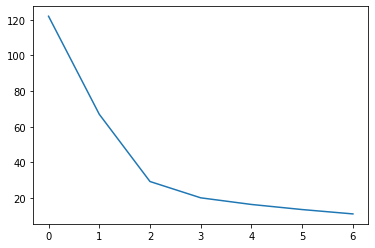

In [30]:
# elbow-curve/ssd (sum of squared distances)
ssd = [] #initiating a new list
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans (n_clusters = num_clusters, max_iter = 50)
    kmeans.fit (rfm_df_scaled)
    ssd.append (kmeans.inertia_)
    
#plot the SSDz for each n_clusters
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [31]:
#data point num (cluster-1)
# p = 100
# q = 10
# 90/100 = 0.9

#data point num 15 (cluster-1)
# p = 10
# q = 12
# -2/12 = -1/6


In [32]:
# silhouette analysis 
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    #initialize kmeans
    kmeans = KMeans (n_clusters = num_clusters, max_iter = 50)
    kmeans.fit (rfm_df_scaled)
    cluster_labels = kmeans.labels_
    #silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, kmeans.labels_)
    print ("For n_clusters = {0}, the silhouette score is {1}".format (num_clusters,silhouette_avg))

For n_clusters = 2, the silhouette score is 0.621762414655195
For n_clusters = 3, the silhouette score is 0.6651155858723083
For n_clusters = 4, the silhouette score is 0.7388832144536907
For n_clusters = 5, the silhouette score is 0.5194479474281173
For n_clusters = 6, the silhouette score is 0.46016222807687285
For n_clusters = 7, the silhouette score is 0.46208842101521613
For n_clusters = 8, the silhouette score is 0.4257259596120097


In [33]:
#final model with k = 3
kmeans = KMeans (n_clusters = 3, max_iter = 50)
kmeans.fit (rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [34]:
kmeans.labels_

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])

In [35]:
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head ()

,CustomerID,amount,frequency,recency,cluster_id
55,12415.0,123725.45,778,23,1
100,12471.0,18740.92,531,1,0
273,12678.0,17588.26,167,41,0
318,12731.0,18793.41,277,23,0
330,12748.0,29072.10,4642,0,1


<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

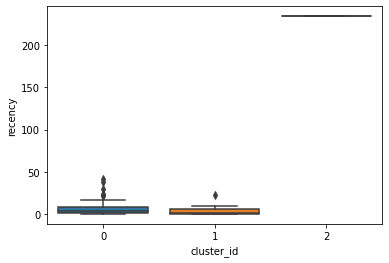

In [36]:
#Lets see distribution of frequencies/amount across clusters 
# plot
sns.boxplot (x = 'cluster_id', y = 'recency', data = grouped_df)

<AxesSubplot:xlabel='cluster_id', ylabel='frequency'>

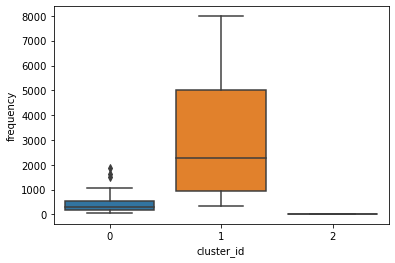

In [37]:
# plot
sns.boxplot (x = 'cluster_id', y = 'frequency', data = grouped_df)

<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

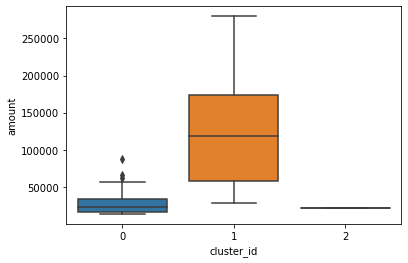

In [38]:
# plot
sns.boxplot (x = 'cluster_id', y = 'amount', data = grouped_df)